In [142]:
import logging
from collections import namedtuple
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor
from matplotlib import pyplot as plt
import numpy as np
import math
import json
import os
from copy import deepcopy, copy
from collections import Counter

from nim_utils import *

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [143]:
class Agent():
    def __init__(self, nim, alpha = 0.1, random_factor = 0.2) -> None:
        self.state_history = []
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(nim)

    def init_reward(self, nim) -> dict:
        result = []
        def generate_states(rows, current_state):
            if len(current_state) == len(rows):
                # We have generated a valid state 
                result.append(current_state)
                return
            # Generate all possible states for the current row
            for i in range(rows[len(current_state)] + 1):
                new_state = current_state + [i]
                generate_states(rows, new_state)
        
        generate_states(nim.rows, [])
        for state in result:
            self.G[Nim(NIM_SIZE_learn, state=state)] = np.random.uniform(low=1.0, high=0.1)     

    def choose_action(self, state) -> Nimply:
        maxG = -10e15
        next_move = None
        possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
        if np.random.random() < self.random_factor:
            next_move = random.choice(possible_moves) 
        else:
            for action in possible_moves:
                # print(f"Action: {action}")
                new_state = deepcopy(state)
                new_state.nimming(action)
                # print(f"Check {new_state}")
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5  # decrease random factor each episode of play

    def get_strategy(self) -> Callable:
        def agent_strategy(state: Nim) -> Nimply:
            action = self.choose_action(state)
            # print(f"Choosen action: {action}")
            return Nimply(action[0], action[1])
        return agent_strategy

In [144]:
NUM_MATCHES = 50
NIM_SIZE = 6

def evaluate_against(strategy: Callable, against: Callable) -> float:
    opponent = (strategy, against)
    won = 0
    for _ in range(NUM_MATCHES):
        nim = Nim(NIM_SIZE)
        player = 0
        while nim:
            # logging.debug(nim)
            ply = opponent[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 1: # winner is the zero
            won += 1
        # logging.debug(f"player {1 - player} has won.")
    return won / NUM_MATCHES

### Reinforcement learning strategies


In [145]:
# Costants
NUM_EPOCHS = 20000
NIM_SIZE_learn = 6
OPPONENTS = [pure_random] * 5 + [aggressive] * 14  + [optimal_strategy] 

# Create the agent
game = Nim(NIM_SIZE_learn)
agent = Agent(game, random_factor=0.2)

states = agent.G

In [146]:
# for state in states:
#     print(f"{state}: {states[state]}")
win_logs = []
scores = []
for i in range(NUM_EPOCHS):
    # logging.debug(f"Starting the game #{i}")
    current_game = Nim(NIM_SIZE_learn)
    turn = True
    OPPONENT = random.choice(OPPONENTS)
    while current_game:
        if turn:
            # my agent turn
            action = agent.choose_action(current_game)
            # print(f"Action: {action}")
            current_game.nimming(action)
            state, reward = current_game.get_state_and_reward()
            # print(f"{state} -> {reward}")
            agent.update_state_history(state, reward)
        else:
            action = OPPONENT(current_game)
            current_game.nimming(action)
        turn = not turn
    winner = int(not turn)
    win_logs.append(winner)
    # logging.debug(f"The game ended. Player {winner} wins")
    agent.learn()
    if i % 500 == 0:
        score = evaluate_against(agent.get_strategy(), OPPONENT)
        scores.append(score)
        print(f"#{i}: {score}")


agent_strategy = agent.get_strategy()


#0: 0.46
#500: 0.42
#1000: 0.44
#1500: 0.4
#2000: 0.42
#2500: 0.5
#3000: 0.4
#3500: 0.48
#4000: 0.4
#4500: 0.4
#5000: 0.3
#5500: 0.42
#6000: 0.5
#6500: 0.42
#7000: 0.32
#7500: 0.28
#8000: 0.46
#8500: 0.44
#9000: 0.46
#9500: 0.26
#10000: 0.34
#10500: 0.28
#11000: 0.5
#11500: 0.54
#12000: 0.52
#12500: 0.44
#13000: 0.3
#13500: 0.4
#14000: 0.46
#14500: 0.36
#15000: 0.52
#15500: 0.3
#16000: 0.36
#16500: 0.5
#17000: 0.44
#17500: 0.46
#18000: 0.4
#18500: 0.48
#19000: 0.38
#19500: 0.4


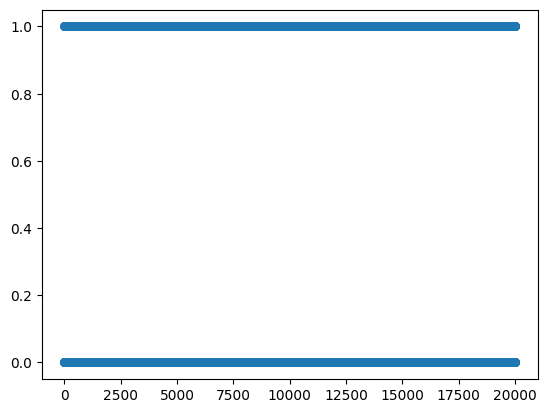

In [147]:
plt.scatter(range(len(win_logs)), win_logs, marker='o', linewidths=.2, edgecolors=None)
plt.show()

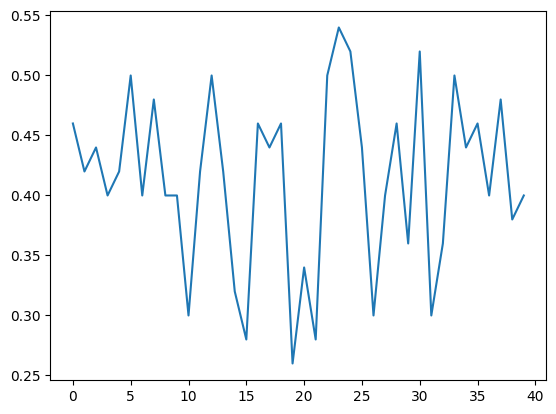

In [148]:
plt.plot(range(len(scores)), scores)
plt.show()

In [149]:
evaluate_against(agent_strategy, optimal_strategy)



0.0